In [2]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss, preprocess_instances, BatchPreProcessor
from config import LIBRISPEECH_SAMPLING_RATE
from voicemap.models import get_baseline_convolutional_encoder, build_siamese_net
from keras.optimizers import Adam
import numpy as np
import pandas as pd
from keras.models import load_model
%load_ext autoreload
%autoreload 2

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
## Initialising all Parameters
n_seconds = 3
downsampling = 4
batchsize = 64
filters = 128
embedding_dimension = 64
dropout = 0.0
input_length = int(LIBRISPEECH_SAMPLING_RATE * n_seconds / downsampling)
model_path = '../models_new/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'

In [4]:
#Load model
encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1), distance_metric='uniform_euclidean')
opt = Adam(clipnorm=1.)
siamese.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#siamese = load_model(model_path)
siamese.load_weights(model_path)

Instructions for updating:
Colocations handled automatically by placer.


## Encoder


In [6]:
from keras.models import Model
from keras.layers import Input

## Load Encoder
inputs = Input(shape=(12000,1))
encoded = siamese.layers[2](inputs)
encoder = Model(inputs=inputs, outputs=encoded)
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

In [7]:
## Training
training_set = ['train-clean-100']
train = LibriSpeechDataset(training_set, 3, stochastic=False, pad=True)#, cache=False)
## Validation
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, 3, stochastic=False, pad=True)#,cache=False)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100']
Finished indexing data. 28442 usable files found.
Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['dev-clean']
Finished indexing data. 2703 usable files found.


In [8]:
batch_preprocessor = BatchPreProcessor("classifier", preprocess_instances(downsampling))
preprocessor = batch_preprocessor

import soundfile as sf
inst, sr = sf.read(train.df['filepath'][0])
block_size = sr*3
abc =[]
for b in sf.blocks(train.df['filepath'][0], blocksize=block_size, overlap=block_size//2):
    print(len(b))


In [9]:
from sklearn.model_selection import train_test_split
## Split the train filenames to train, val_speakers

speaker_list=train.df["speaker_id"]
train_arr_filenames=train.df['filepath']
print(train_arr_filenames.shape)

indices = np.arange(len(train_arr_filenames))
ind_train, ind_test = train_test_split(indices, test_size=0.33, random_state=42)
train_arr_filenames[ind_train]
X_train_files = train_arr_filenames[ind_train]
X_test_files = train_arr_filenames[ind_test]
y_train = speaker_list[ind_train]
y_test = speaker_list[ind_test]

(28442,)


## Split the train to train, val_speakers

In [11]:
#Read split
import pandas as pd
train_=pd.read_csv('train_split.csv')
val_=pd.read_csv('val_split.csv')

In [ ]:
import pandas as pd
train_=pd.DataFrame({"X_train": X_train, "speaker_id":y_train})
val_=pd.DataFrame({"X_test": X_test, "speaker_id":y_test})
#train_.to_csv('train_split.pkl')
#val_.to_csv('val_split.pkl')

In [12]:
train_["X_train"].shape

(19056,)

#Computing the mean of each speaker encoding
speaker_list=np.unique(train_["speaker_id"])
train_spkr_means=[]
for speaker in speaker_list:
    spkr_index=train_[train_["speaker_id"]==speaker].index.values
    emb=[]
    for ind in spkr_index:
        query_instance = preprocessor.instance_preprocessor(
                train_["X_train"][ind].reshape(1,-1,1)
            )
        emb.append(encoder.predict(query_instance))
    mean_spkr_embedding=np.mean(emb, axis=0)
    train_spkr_means.append(mean_spkr_embedding)
train_spkr_means=np.stack(train_spkr_means)


In [28]:
#import pickle
#with open('train_spkr_means_e35_full.pkl', 'wb') as f:
#    pickle.dump(train_spkr_means, f)
#with open('train_spkr_list_e35_full.pkl', 'wb') as f:
#    pickle.dump(speaker_list, f)

import pickle
with open('train_spkr_means_cluster.pkl', 'rb') as f:
    train_spkr_means = pickle.load(f)
with open('train_spkr_list_cluster.pkl', 'rb') as f:
    speaker_list=pickle.load(f)

x=train_spkr_means
x=x.reshape(250,64,-1)
train_spkr_means

#trained_spkr_embeddings=trained_speakers["mean_embedding"]
#num_classes = len(np.unique(trained_speakers["speaker_id"]))
#trained_spkr_embeddings=train_spkr_means
#num_classes = len(np.unique(speaker_list))
correct=0
for ind in val_.index.values:
    query_instance = preprocessor.instance_preprocessor(
                val_["X_test"][ind].reshape(1, -1, 1)
            )
    query_emb=encoder.predict(query_instance)
    # Get euclidean distances between mean embeddings
    pred = np.sqrt(
        np.power(
            (
                train_spkr_means-query_emb
            ),
            2,
        ).sum(axis=1).sum(axis=1)
    )
    #print(np.argmin(pred),val_["speaker_id"][ind],ind)
    if speaker_list[np.argmin(pred)] == val_["speaker_id"][ind]:
        correct+=1
    print(speaker_list[np.argmin(pred)], val_["speaker_id"][ind])
print("Num correct", correct)
print("total", len(val_))

correct/len(val_)
#val_["X_test"][96].reshape(1,-1,1)

def compute_distances_no_loops(A, B):
    dists = -2 * np.dot(A, B.T) + np.sum(B**2,    axis=1) + np.sum(A**2, axis=1)[:, np.newaxis]
    return dists
A=train_spkr_means.reshape(-1,64)

count=0
val_spkr =np.unique(val_["speaker_id"])
acc=[0]*val_spkr
res=[]
for i in range(len(val_spkr)):
    spkr1=val_[val_["speaker_id"] == val_spkr[i]]["X_test"]
    spkr1.reset_index(drop = True)
    spkr1_=np.stack(x for x in spkr1.reset_index(drop = True))
    spkr1_instance = preprocessor.instance_preprocessor(
                    spkr1_[:,:,np.newaxis] )
    spkr1_emb=encoder.predict(spkr1_instance)
    B=spkr1_emb
    pred=compute_distances_no_loops(A, B).T
    pred_spkrs,counts = np.unique(speaker_list[np.argmin(pred, axis=1)],return_counts = True )
    if pred_spkrs[np.argmax(counts)] == val_spkr[i]:
        count+=1
    res.append([i,pred_spkrs, counts,val_spkr[i]])

In [ ]:
#query_sample, support_set_samples = train.build_n_shot_task(5, 1)
y_val

# Classifier of Embeddings

In [13]:
def read_data(input_data, train=train):
    X_array =[]
    for i in input_data.index.values:
        #instance, sr = sf.read(input_data[i])
        instance, sp = train[i]
        X_array.append(instance)
    X_array = np.array(X_array)
    return X_array

In [14]:
def extract_embedding(X_array, encoder):
    query_instance_ = preprocessor.instance_preprocessor(X_array[:,:,np.newaxis])
    emb = encoder.predict(query_instance_)
    return emb

In [15]:
## Changed from train to valid
X_read = read_data(X_train_files, train)
print(X_read.shape)
val_read = read_data(X_test_files,train)
print(val_read.shape)

KeyboardInterrupt: 

In [12]:
emb = extract_embedding(X_read, encoder)

In [13]:
val_emb = extract_embedding(val_read, encoder)

In [14]:
from sklearn import svm
## Train Classifier
X_tr = emb
y_tr = y_train
clf = svm.SVC(gamma = 'scale', probability=True)
clf.fit(X_tr, y_tr) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
y_pred = clf.predict(val_emb)
probs = clf.predict_proba(val_emb)
y_val = y_test
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.8666098444491797


In [17]:
## Plotting prob distribution

correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]

##Unknown
unknown, sr = valid[100]
query_instance_ = preprocessor.instance_preprocessor(unknown.reshape(1,-1,1))
emb_unknown = encoder.predict(query_instance_)
probs_unknown = clf.predict_proba(emb_unknown)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2)
ax[0,0].plot(correct_probs[0],'g')
ax[0,0].set_ylabel('Probability')
ax[0,0].set_xlabel('Speaker class')
ax[0,0].set_title('Correct Classification')

ax[0,1].plot(incorrect_probs[0], 'r')
ax[0,1].set_ylabel('Probability')
ax[0,1].set_xlabel('Speaker class')
ax[0,1].set_title('Misclassification')

ax[1,0].plot(probs_unknown[0],'b')
ax[1,0].set_ylabel('Probability')
ax[1,0].set_xlabel('Speaker class')
ax[1,0].set_title('Unknown speaker')

ax[1,1].plot(correct_probs[0],'g')
ax[1,1].plot(incorrect_probs[100], 'r')
ax[1,1].plot(probs_unknown[0],'b')
ax[1,1].set_ylabel('Probability')
ax[1,1].set_xlabel('Speaker class')
ax[1,1].legend(['Correct', 'Misclassify', 'Unknown'],fontsize =4, loc=1)
ax[1,1].set_title('Combined')
plt.tight_layout()
plt.show()
fig.savefig('plots_3sec.png', dpi=250)

<Figure size 640x480 with 4 Axes>

In [26]:
#Compute kurosis
from scipy.stats import kurtosis
kurtosis(probs_unknown, axis=1)
kurtosis(probs, axis = 1)
correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]
print("Kurtosis for correct predictions: Mean:", np.mean(kurtosis(correct_probs, axis=1)), 
      "Std:", np.std(kurtosis(correct_probs, axis=1)),
      "\nKurtosis for incorrect predictions: Mean:",
      np.mean(kurtosis(incorrect_probs, axis =1)), "Std:",
      np.std(kurtosis(incorrect_probs, axis=1)),
      "\nKurtosis of one Unknown file:",
      kurtosis(probs_unknown, axis=1))
#probs_unknown


Kurtosis for correct predictions: Mean: 203.82340640261293 Std: 49.87805813441787 
Kurtosis for incorrect predictions: Mean: 123.20446374862435 Std: 53.5608958446859 
Kurtosis of one Unknown file: [162.16805625]


In [89]:
# Mean probability to calculate threshold

print(np.mean(np.max(correct_probs, axis=1)), np.std(np.max(correct_probs, axis=1)))
print(np.mean(np.max(incorrect_probs, axis=1)), np.std(np.max(incorrect_probs, axis=1)))

np.mean(np.max(probs_unknown, axis=1))

0.5089594407023855 0.1696853479744132
0.3110568836946897 0.136879459739754


0.2530405171933147

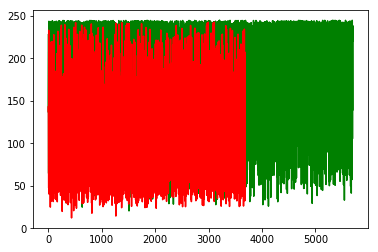

In [251]:
## Plot kutisis
plt.plot(kurtosis(correct_probs, axis =1), 'g')
plt.plot(kurtosis(incorrect_probs, axis=1), 'r')
plt.plot(kurtosis(probs_unknown, axis=1),'b')

def plot_confusion_matrix(cm,classes,
                          title=None,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(250,250))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
classes = np.arange(250)
plot_confusion_matrix(cm,classes,title='Confusion matrix')
#plt.show()

In [ ]:
#models_e50_cluster, Models_e50_full, #Models_new, n=1seconds, n=2seconds,
0.031216, 0.005327, 0.867, 0.25708, 0.1867

### Experiment with varying num-speakers

In [18]:
def num_speakers_train(X_train_files, y_train, two_spkr, emb=None):
    X_two_train =[]
    y_two_train =[]
    if emb is None:
        spkr1=X_train_files[y_train == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = emb[y_train == two_spkr[0]]
    X_two_train = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_train = y_spkr1
    
    for i in range(1, len(two_spkr)):
        if emb is None:
            spkr1=X_train_files[y_train == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = emb[y_train == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_train = np.vstack((X_two_train,spkr1_emb))
        y_two_train = np.hstack((y_two_train,y_spkr1))
    
    return (X_two_train, y_two_train)

In [19]:
def num_speakers_val(X_test_files, y_test, two_spkr, val_emb = None):
    X_two_val =[]
    y_two_val =[]
    if val_emb is None:
        spkr1=X_test_files[y_test == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = val_emb[y_test == two_spkr[0]]
    X_two_val = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_val = y_spkr1

    for i in range(1, len(two_spkr)):
        if val_emb is None:
            spkr1=X_test_files[y_test == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = val_emb[y_test == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_val = np.vstack((X_two_val,spkr1_emb))
        y_two_val = np.hstack((y_two_val,y_spkr1))
    
    return (X_two_val, y_two_val)

In [21]:
from sklearn.metrics import accuracy_score
num_speakers = 3
##Try multiple times and average out
num_reps = 5

acc=[]
print("Num Speakers:", num_speakers)
for i in range(num_reps):
    two_spkr = np.random.choice(np.unique(y_train),num_speakers)
    #print("Trial:", i)
    #, "Speakers:", two_spkr)
    X_two_train, y_two_train = num_speakers_train(X_train_files, y_train, two_spkr, emb)
    clf2 = svm.SVC(gamma = 'scale', probability=True)
    clf2.fit(X_two_train, y_two_train) 
    
    X_two_val, y_two_val = num_speakers_val(X_test_files, y_test, two_spkr, val_emb)
    y_pred = clf2.predict(X_two_val)
    y_val = y_two_val
    acc.append(accuracy_score(y_val, y_pred))
    #print("Accuracy:",acc[i])
print(np.mean(np.array(acc)), np.std(np.array(acc)))

Num Speakers: 3
0.9983739837398374 0.003252032520325221


## Plot and gif

In [57]:
import soundfile as sf

In [25]:
#Create a combines audio file of randomly selected files
f1 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[0]].index.values[0]]
f2 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[1]].index.values[0]]
f3 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[2]].index.values[0]]
files = [f1, f2, f3]
data = [0]
for f in files:
    inst, sr = sf.read(f)
    data = np.concatenate((data,inst))
data.shape
sf.write('new_combined_file.flac', data, sr)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

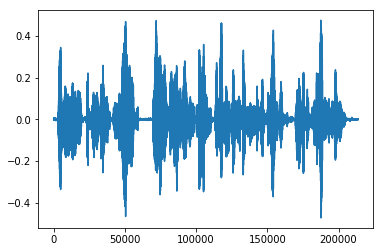

In [56]:
## Plot of a sound file
plt.plot(sf.read(f1)[0])

In [28]:
import soundfile as sf
filepath = '/Users/sanmathikamath/projects/datasets/arctic/combined_Librispeech_full_89_4014_8770.flac'
files = ['new_combined_file.flac']
inst, sr = sf.read(filepath)
block_size = sr*3
# blocks_ = np.zeros(block_size)
instances = []
for f in files:
    blocks = sf.blocks(f, blocksize=block_size, overlap = block_size - sr)
    for j in blocks :
        instances.append(j)
    instances = instances[:-1]

instances=np.array(instances)
prob_two = clf2.predict_proba(extract_embedding(np.array(instances), encoder))
prob_two.shape

(28, 3)

In [29]:
y_two = np.argmax(prob_two, axis=1)

In [124]:
cumulative_prob_two = np.zeros(prob_two.shape)
cumulative_prob_two[0]= prob_two[0]
for i in range(1,len(prob_two)):
    cumulative_prob_two[i] = (prob_two[i]+cumulative_prob_two[i-1])/np.sum(prob_two[i]+cumulative_prob_two[i-1])
    #print(cumulative_prob_two[i])
#prob_two[:5], cumulative_prob_two[:5]
#(prob_two[1]+prob_two[0])/np.sum(prob_two[1]+prob_two[0])

(array([[0.28823934, 0.59010184, 0.12165883],
        [0.29529533, 0.58188043, 0.12282424],
        [0.30160162, 0.57841541, 0.11998296],
        [0.30938837, 0.5746082 , 0.11600344],
        [0.31251849, 0.57677597, 0.11070553]]),
 array([[0.28823934, 0.59010184, 0.12165883],
        [0.29176733, 0.58599113, 0.12224153],
        [0.29668448, 0.58220327, 0.12111225],
        [0.30303642, 0.57840573, 0.11855784],
        [0.30777746, 0.57759085, 0.11463169]]))

In [30]:
prob_two = clf2.predict_proba(X_two_val)

In [38]:
import matplotlib.cbook as cbook
img_file_path ='/Users/sanmathikamath/projects/Speaker_Recognition/voicemap-master/notebooks/neutral_C.png'
with cbook.get_sample_data(img_file_path) as image_file:
    imageC = plt.imread(image_file)


In [39]:
images=[imageA,imageB,imageC]

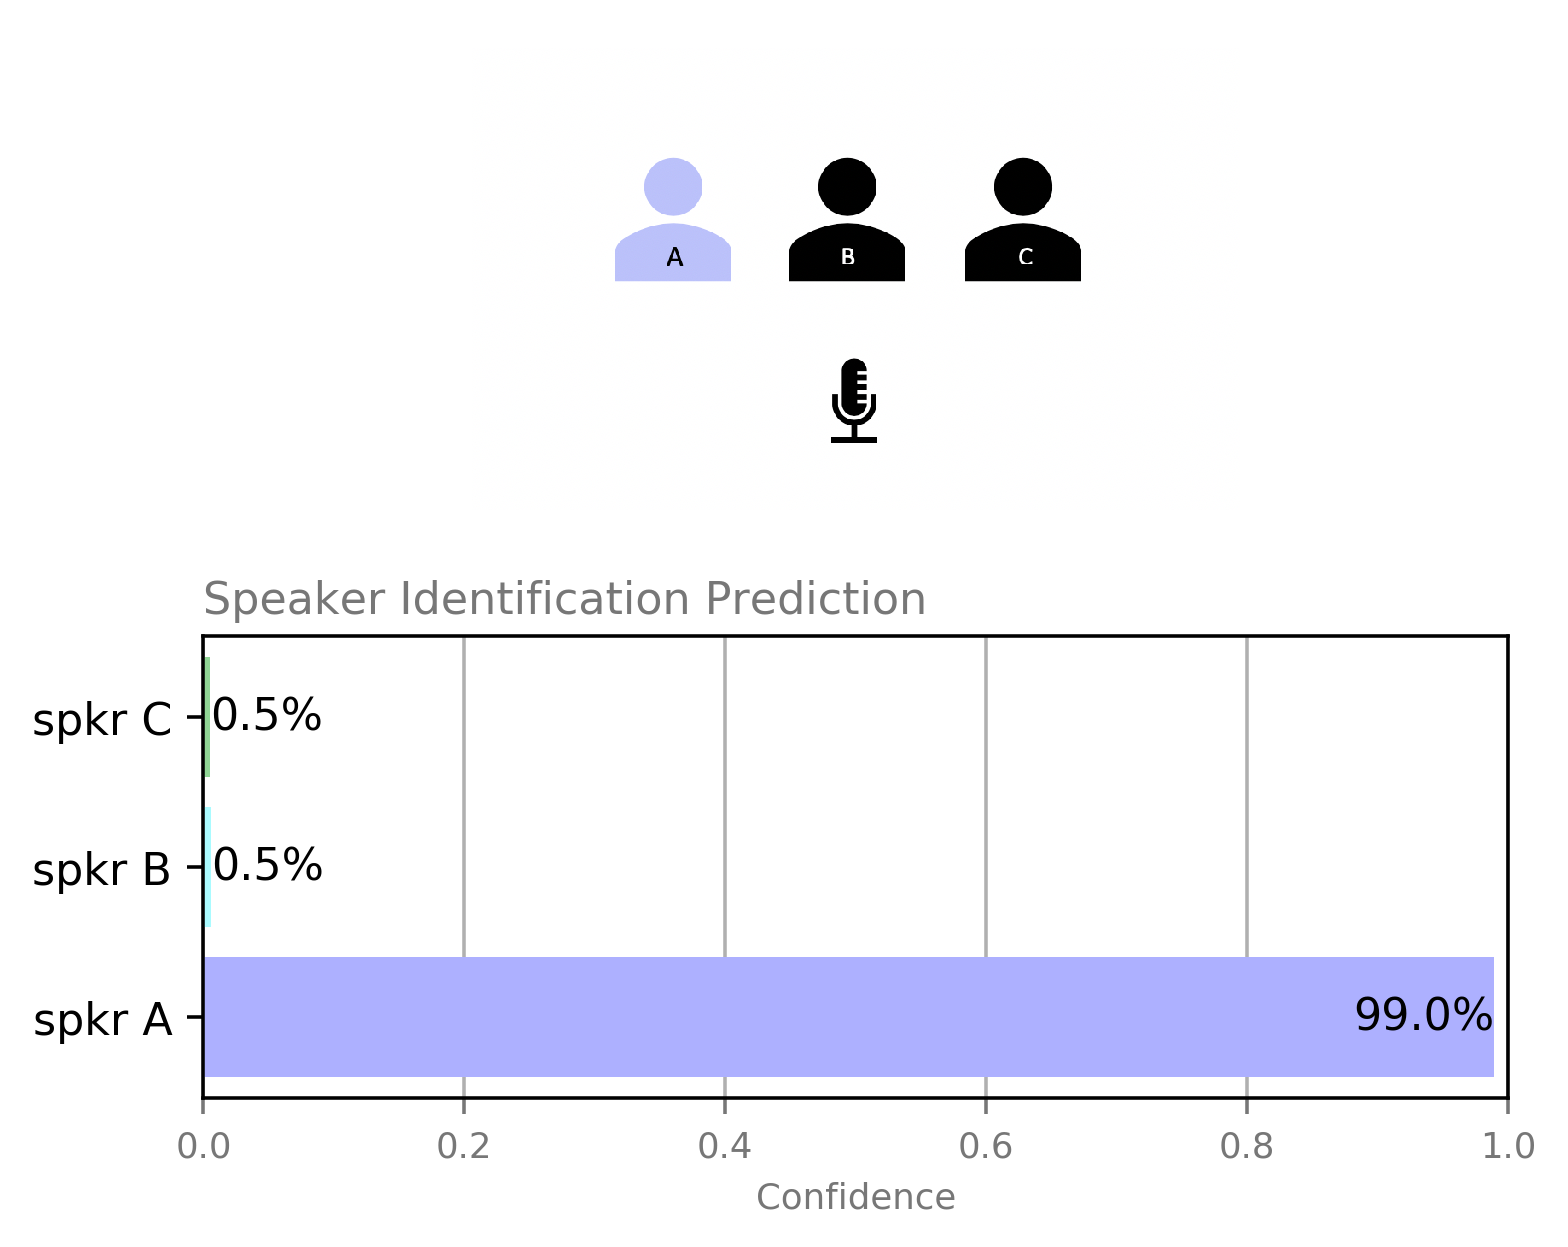

In [53]:
fig, ax = plt.subplots(nrows=2,figsize=(5,4), dpi = 320)
def draw_barchart(sp_i, fig=fig, ax=ax):
    ax[0].imshow(images[y_two[sp_i]])
    ax[0].set_axis_off()
    
    ax = ax[1]
    ax.clear()
    spkr_names_three = ['spkr A', 'spkr B', 'spkr C']
    #spkr_names_three = [str(x) for x in np.unique(y_two_val)]
    colors = dict(zip(
        spkr_names_three,
        ['#adb0ff', '#aafbff', '#90d595']
    ))
    
    ax.barh(spkr_names_three, prob_two[sp_i], color=[colors[x] for x in spkr_names_three])
    ax.set_xlim(0,1)
    # iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
    for i, (value, name) in enumerate(zip(prob_two[sp_i], spkr_names_three)):
        #ax.text(value, i,     name, size=14, weight=600, ha='right', va='bottom')  # Tokyo: name
        if value < 0.5:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='left',  va='center')   # 38194.2: value
        else:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='right',  va='center')   # 38194.2: value
    ax.text(0, 1.05, 'Speaker Identification Prediction',
                transform=ax.transAxes, size=10, weight=100, ha='left',  color='#777777')
    
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Confidence',color='#777777', size=8)
    #ax.set_ylabel('Speaker')
    ax.tick_params(axis='x', colors='#777777', labelsize=8)
    #ax.text(1, -0.15, 'by @sanmathikamath', transform=ax.transAxes, ha='right', size =6,
    #        color='#777777', bbox=dict(facecolor='white', alpha=0.2, edgecolor='white'))
    
    #ax.set_yticks([])
    #ax.margins(0, 0.01)
    
    #plt.subplots_adjust(left = 0.2, right=0.70,  top=1.1, bottom=0.1 )
    
    plt.box(True)
    plt.tight_layout()
draw_barchart(0, fig, ax)
plt.savefig('overview.png', dpi=250)

IndexError: index 28 is out of bounds for axis 0 with size 28

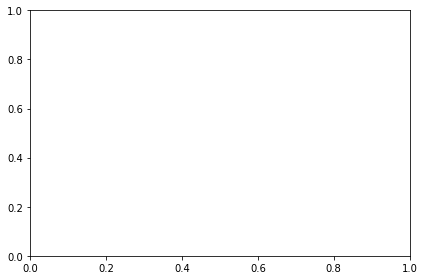

In [52]:
import matplotlib.animation as animation
from IPython.display import HTML
#fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0,len(prob_two)))
HTML(animator.to_jshtml())
#HTML(animator.save('gif1.mp4'))

In [16]:
## Acc plots over num_speakers
import matplotlib.pyplot as plt
n = [2,4,6,10,20]
acc= [99.07 ,98.56, 87.65, 79.601, 65.539]
plt.bar(n, acc)
plt.xlabel('Number of speakers')
plt.ylabel('Classification Accuracy')
plt.show()

Text(0,0.5,'Classification Accuracy')

### Plot of prediction using sliding window 
Splitting one file into its various windows

In [109]:
testing_files_ind = np.random.choice(X_test_files.index.values, 3)
testing_files = X_test_files[testing_files_ind]
testing_files
output_test = y_test[testing_files_ind]
testing_files

11255    /Users/sanmathikamath/projects/voicemap-master...
27001    /Users/sanmathikamath/projects/voicemap-master...
26674    /Users/sanmathikamath/projects/voicemap-master...
Name: filepath, dtype: object

In [110]:
import soundfile as sf
sr = 16000
block_size = n_seconds*sr
output_labels_pred =[]
for file in testing_files:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/2514/149482/2514-149482-0021.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8324/286682/8324-286682-0032.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8238/283452/8238-283452-0037.flac


In [111]:
output_labels_pred, output_test

([array([3240, 2136, 7264, 7264, 2911, 6181, 2514, 2911, 2911]),
  array([5339,  831, 7226, 6454, 8095, 8095, 6454, 4267,  831]),
  array([ 211,  103,  125, 1116, 1235,  460, 1867, 1116, 8419])],
 11255    2514
 27001    8324
 26674    8238
 Name: speaker_id, dtype: int64)

### Plot of prediction using sliding window over multiple files
Splitting one file into its various windows and combining multiple files of same speaker

In [113]:
test_speakers = np.random.choice(np.unique(y_test), 3)

In [114]:
output_labels_pred =[]
for spkr_j in test_speakers:
    print(spkr_j)
    spkr_j_ind = y_test[y_test == spkr_j].index.values
    spkr_files = X_test_files[spkr_j_ind]
    instances=[]
    for file in spkr_files:
        blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
        for j in blocks :
            instances.append(j)
        instances = instances[:-1]
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

6454
8324
1970


In [110]:
output_labels_pred, test_speakers

([array([ 289, 1867, 1867, 1867, 1867, 1867, 7635, 7635, 1867, 7635, 1867,
         1867, 1867, 1867, 7635, 7635, 1867, 1867, 1867, 1867, 1867,  289,
          289,  289,  289, 1867, 7059, 7059, 7059,   39, 4406, 4406, 4406,
         7635, 7635, 7635, 4406, 1867, 1867, 1867, 1867, 1867, 1867, 1867,
         1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 7059,
          289, 1867, 1867, 4406, 4406, 4406, 3982, 7635, 3982, 3982, 1867,
         7635, 7635, 1867, 4406, 4406, 1867, 1867, 1867, 1867, 3982, 1867,
         7635, 4406, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 4406, 4406,
         1867,  289, 1867, 1867, 7635, 7635, 3982, 3982, 7635, 7635, 1867,
         1867, 7635,  289, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 7635,
         4406, 1867, 1867, 4406, 4406, 1867, 4406, 4406, 3982, 1867, 1867,
         1867, 7635, 1867, 1867,  289, 1867, 1867, 7635, 3112, 2989, 1867,
         7635,   39, 1867, 1867, 1867,   39, 1867, 1867, 1867, 7635, 1867,
         1867, 3982, 1867

In [118]:
from collections import Counter
print("Predicted_label:", Counter(output_labels_pred[0]).most_common(1)[0][0], "\nActual label:",test_speakers[0])

Predicted_label: 6454 
Actual label: 6454


In [149]:
##Unknown speaker predictions for sliding window
unknown = valid.df['filepath'][0]
import soundfile as sf
sr = 16000
n_seconds=3
block_size = n_seconds*sr
output_labels_pred =[]
for file in [unknown]:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/dev-clean/84/121123/84-121123-0026.flac


In [146]:
output_labels_pred

[array([5778, 1502, 8123, 5778, 1502, 1502, 1502, 5778])]

In [150]:
accuracy_score(y_val, y_pred)

0.8666098444491797

In [162]:
# #EER
# from sklearn.metrics import roc_curve
# fpr, tpr, threshold = roc_curve(y_val, y_pred)
# fnr = 1 - tpr
# eer_threshold = threshold(np.nanargmin(np.absolute((fnr - fpr))))
# EER = fpr(np.nanargmin(np.absolute((fnr - fpr))))
# print(EER)

In [163]:
probs = clf.predict_proba(val_emb)
probs

AttributeError: predict_proba is not available when  probability=False

### KMeans Clustering

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
X_train = emb
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(data))))

    return estimator

In [42]:
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
km = bench_k_means(KMeans(init='random', n_clusters=250, n_init=10),
              name="random initialization", data=X_train, labels = y_train)


init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random initialization	15.81s	400260	0.815	0.822	0.818	0.512	0.760	0.213


In [154]:
y_clus = km.predict(X_train)
np.unique(y_clus)

0.00020990764063811922

## Code Profiling